# Adversarial Autoencoders with the CIFAR-10 Dataset
See http://arxiv.org/pdf/1511.05644v1.pdf

In [7]:
import numpy as np
import sys
import tensorflow as tf
import time

import load_cifar10
import ops

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm

FLOAT = tf.float32

## Load in the dataset and take a gander

In [8]:
batches = load_cifar10.Batches()
train_batches = batches[:5]
train_images = np.concatenate(train_batches)
test_batch = batches[5]

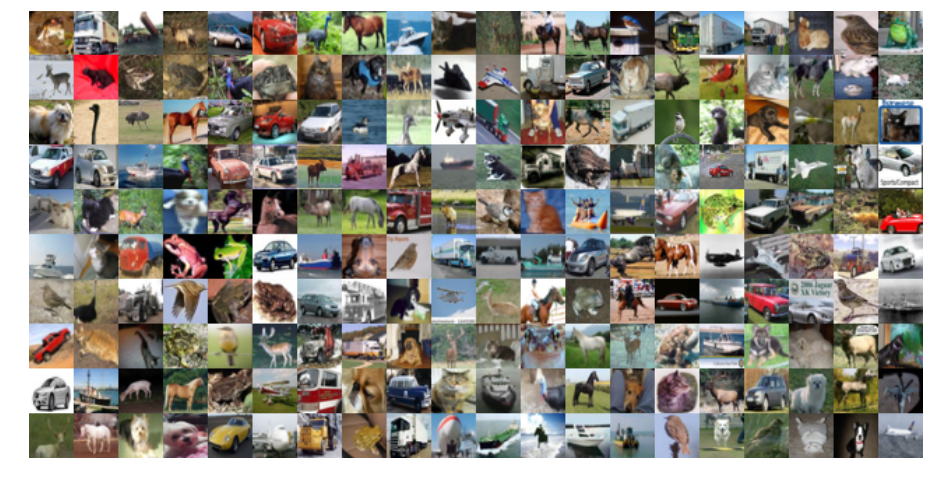

In [9]:
figsize(16, 8)
plt.imshow(
    np.concatenate(
        [np.concatenate(list(train_images[i * 20:(i + 1) * 20]), axis=1)
         for i in xrange(10)]))
plt.axis("off")
plt.show()

In [10]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

no existing session to delete


### Base Autoencoder Class

In [108]:
class BaseAutoencoder(object):
    
    def __init__(
            self, sess,
            input_shape=[32, 32, 3],
            name="BaseAutoencoder"):
        self.sess = sess
        self.input_shape = input_shape
        self.name = name
        
        # Layers of note
        self.z = None
        self.outputs = None
        
        # Book keeping
        self.training_examples_seen = 0
        self.train_error_history = []
        self.test_error_history = []

        # Initialization
        self._BuildNet()
        self.sess.run(tf.initialize_all_variables())
    
    def _BuildEncoder(self):
        # Input to first layer should be self.inputs.
        # Set self.z to last added layer. 
        raise NotImplementedError

    def _BuildDecoder(self):
        # Input to first layer should be self.z.
        # Set self.outputs to last added layer.
        raise NotImplementedError

    def _BuildNet(self):
        with tf.name_scope(self.name) as ns:
            self.inputs = tf.placeholder(
                tf.float32,
                [None] + self.input_shape,
                name="Inputs")
            self._BuildEncoder()
            self._BuildDecoder()
            self.error = tf.sqrt(tf.reduce_mean(tf.square(self.outputs - self.inputs)))
            self.learn_rate = tf.placeholder(tf.float32, name="LearnRate")
            self.train_step = tf.train.AdamOptimizer(self.learn_rate).minimize(self.error)

    def Test(self, test_images):
        (err,) = self.sess.run([self.error], feed_dict={self.inputs: test_images})
        self.test_error_history.append((self.training_examples_seen, err))

    def ReportTestError(self):
        print "\nAfter {tes} training examples, test error = {e:.5f}".format(
            tes=self.training_examples_seen,
            e=self.test_error_history[-1][-1])

    def ReportTrainError(self):
        print "After {tes} training examples, training error = {e:.5f}".format(
            tes=self.training_examples_seen,
            e=self.train_error_history[-1][-1])
  
    def TrainingEpoch(self, train_images, batch_size, learn_rate, report_every_n_batches):
        batches_per_epoch = len(train_images) / batch_size
        np.random.shuffle(train_images)
        for batch in xrange(batches_per_epoch):
            start_offset = batch * batch_size
            stop_offset = start_offset + batch_size
            _, err = self.sess.run(
                [self.train_step, self.error],
                feed_dict={
                    self.inputs: train_images[start_offset:stop_offset],
                    self.learn_rate: learn_rate})
            self.training_examples_seen += batch_size
            self.train_error_history.append((self.training_examples_seen, err))
            if (batch + 1) % report_every_n_batches == 0:
                self.ReportTrainError()

    def ShowExamples(self, images):
        try:
            figsize(16, 2)
        except:
            pass
        (reconst,) = self.sess.run([self.outputs], feed_dict={self.inputs: images})
        plt.imshow(
            np.concatenate(
                [np.concatenate(list(images), axis=1),
                 np.concatenate(list(reconst), axis=1)]))
        plt.axis("off")
        plt.show()

    def Train(
            self, train_images, test_images,
            batch_size, learn_rate, epochs,
            report_every_n_batches, show_examples):
        self.Test(test_images)
        self.ReportTestError()
        for ep in xrange(epochs):
            print "\nStarting Training Epoch {}".format(ep)
            self.TrainingEpoch(train_images, batch_size, learn_rate, report_every_n_batches)
            self.Test(test_images)
            self.ReportTestError()
            if show_examples:
                self.ShowExamples(test_images[:16])

### Simple Autoencoder
With fully connected encoder and decoder.

In [109]:
class SimpleAutoencoder(BaseAutoencoder):
    
    def __init__(
            self, sess,
            first_hidden_layer_size=1024,
            encoding_steps=2,
            name="SimpleAutoencoder",
            **kwargs):
        self.first_hidden_layer_size = first_hidden_layer_size
        self.encoding_steps=encoding_steps
        BaseAutoencoder.__init__(self, sess, name=name, **kwargs)

    def _BuildEncoder(self):
        flattened = tf.reshape(
            self.inputs,
            [-1, np.prod(self.input_shape)],
            name="Flatten")
        self.layers = [flattened]
        self.layer_sizes = (
            [int(flattened.get_shape()[-1])] +
            [self.first_hidden_layer_size / (2 ** x)
             for x in xrange(self.encoding_steps)])
        for x in xrange(self.encoding_steps):
            _, _, enc_layer = ops.HiddenLayer(
                self.layers[-1],
                [self.layer_sizes[x], self.layer_sizes[x + 1]],
                nonlin=tf.nn.relu,
                scope="Enc{}".format(x))
            self.layers.append(enc_layer)
        self.z = self.layers[-1]
    
    def _BuildDecoder(self):
        for x in reversed(xrange(self.encoding_steps)):
            _, _, dec_layer = ops.HiddenLayer(
                self.layers[-1],
                [self.layer_sizes[x + 1], self.layer_sizes[x]],
                nonlin=tf.nn.sigmoid if x == 0 else tf.nn.relu,
                scope="Dec{}".format(x))
            self.layers.append(dec_layer)
        self.outputs = tf.reshape(self.layers[-1], [-1] + self.input_shape)

In [126]:
sa = SimpleAutoencoder(
    sess,
    encoding_steps=1,
    first_hidden_layer_size=1024)


After 0 training examples, test error = 0.25633

Starting Training Epoch 0
After 10000 training examples, training error = 0.17945
After 20000 training examples, training error = 0.16125
After 30000 training examples, training error = 0.15277
After 40000 training examples, training error = 0.14123
After 50000 training examples, training error = 0.14593

After 50000 training examples, test error = 0.13934


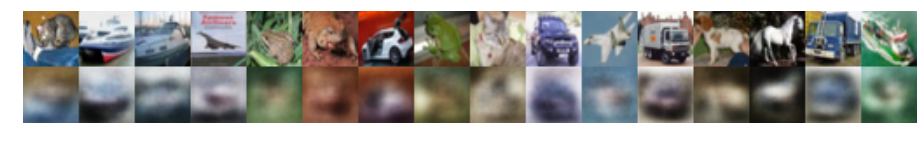


Starting Training Epoch 1
After 60000 training examples, training error = 0.13114
After 70000 training examples, training error = 0.12190
After 80000 training examples, training error = 0.11892
After 90000 training examples, training error = 0.13308
After 100000 training examples, training error = 0.12017

After 100000 training examples, test error = 0.11546


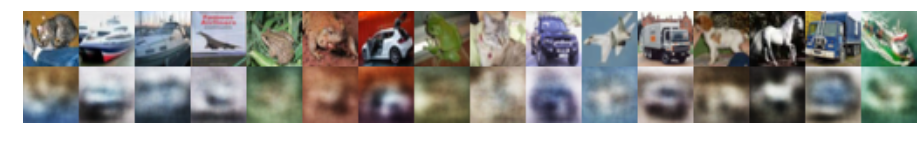


Starting Training Epoch 2
After 110000 training examples, training error = 0.11433
After 120000 training examples, training error = 0.11101
After 130000 training examples, training error = 0.12603
After 140000 training examples, training error = 0.10835
After 150000 training examples, training error = 0.10312

After 150000 training examples, test error = 0.10333


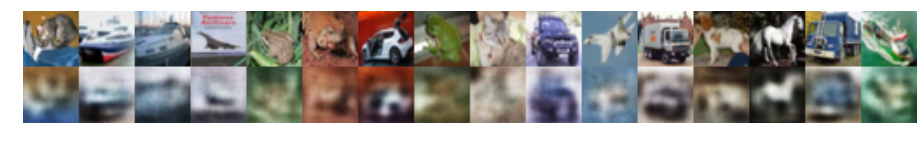


Starting Training Epoch 3
After 160000 training examples, training error = 0.10171
After 170000 training examples, training error = 0.10345
After 180000 training examples, training error = 0.09836
After 190000 training examples, training error = 0.10748
After 200000 training examples, training error = 0.09899

After 200000 training examples, test error = 0.10026


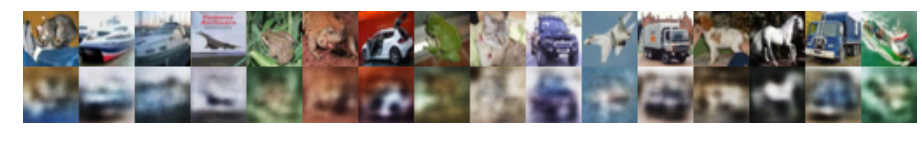


Starting Training Epoch 4
After 210000 training examples, training error = 0.10298
After 220000 training examples, training error = 0.09183
After 230000 training examples, training error = 0.09604
After 240000 training examples, training error = 0.09810
After 250000 training examples, training error = 0.09507

After 250000 training examples, test error = 0.09424


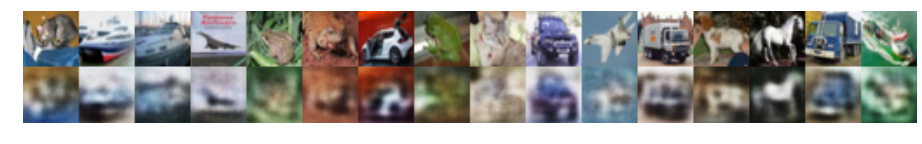


Starting Training Epoch 5
After 260000 training examples, training error = 0.09705
After 270000 training examples, training error = 0.09193
After 280000 training examples, training error = 0.09327
After 290000 training examples, training error = 0.09538
After 300000 training examples, training error = 0.08358

After 300000 training examples, test error = 0.09087


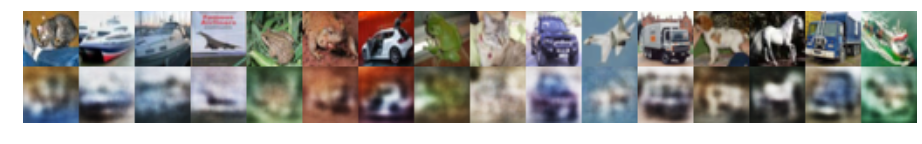


Starting Training Epoch 6
After 310000 training examples, training error = 0.09119
After 320000 training examples, training error = 0.09173
After 330000 training examples, training error = 0.08660
After 340000 training examples, training error = 0.08533
After 350000 training examples, training error = 0.08609

After 350000 training examples, test error = 0.08866


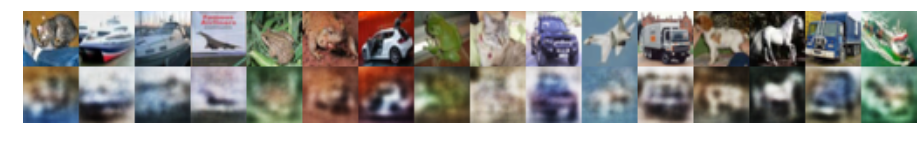


Starting Training Epoch 7
After 360000 training examples, training error = 0.08803
After 370000 training examples, training error = 0.09257
After 380000 training examples, training error = 0.08838
After 390000 training examples, training error = 0.08776
After 400000 training examples, training error = 0.08977

After 400000 training examples, test error = 0.08738


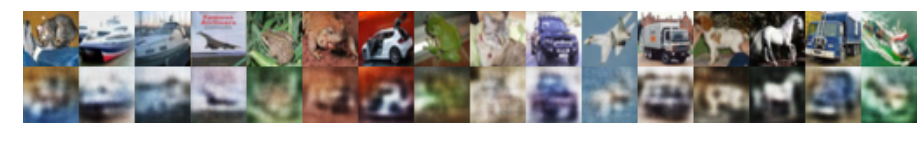


Starting Training Epoch 8
After 410000 training examples, training error = 0.09015
After 420000 training examples, training error = 0.08076
After 430000 training examples, training error = 0.08270
After 440000 training examples, training error = 0.08565
After 450000 training examples, training error = 0.08863

After 450000 training examples, test error = 0.08858


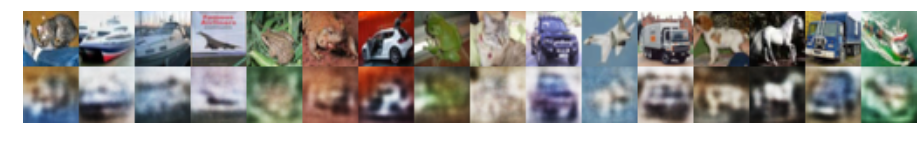


Starting Training Epoch 9
After 460000 training examples, training error = 0.08576
After 470000 training examples, training error = 0.08292
After 480000 training examples, training error = 0.07744
After 490000 training examples, training error = 0.08060
After 500000 training examples, training error = 0.08170

After 500000 training examples, test error = 0.08405


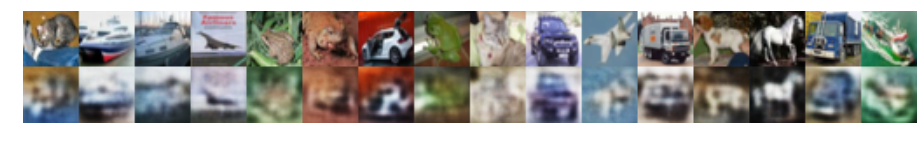

In [127]:
sa.Train(
    train_images=train_images,
    test_images=test_batch[:100],
    batch_size=100,
    learn_rate=0.001,
    epochs=10,
    report_every_n_batches=100,
    show_examples=True)

### Simple Encoder, Convolutional Decoder
Encoder is fully connected. Decoder uses "fractionally strided convolutions", which project an NxN patch on the input layer onto a 2Nx2N patch on the next layer.

In [119]:
class SimpleEncoderConvDecoder(SimpleAutoencoder):
    
    def __init__(
            self, sess,
            channel_scaler=4,
            name="SimpleEncoderConvDecoder",
            **kwargs):
        self.channel_scaler = channel_scaler
        SimpleAutoencoder.__init__(self, sess, name=name, **kwargs)
        if len(self.input_shape) != 3:
            raise ValueError("Input shape must be a list of length 3.")
        if self.input_shape[0] != self.input_shape[1]:
            raise ValueError("First two elements of input shape must be equal.")

    def _BuildDecoder(self):
        decoding_layers = int(np.ceil(np.log2(self.input_shape[0]))) - 2
        channels = (2 ** (decoding_layers - 1)) * self.input_shape[-1] * self.channel_scaler
        resolution = 4
        proj_size = 16 * channels
        z_size = int(self.z.get_shape()[-1])
        
        # Project z into a narrow, deep prism.
        # This part isn't trainable, it's just a dumb linear transform.
        W_proj = tf.constant(
            np.random.normal(0, 0.02, size=z_size * proj_size),
            dtype=tf.float32,
            shape=[z_size, proj_size])
        proj = tf.reshape(
            tf.matmul(self.z, W_proj),
            [-1, 4, 4, channels],
            name="DecProjection")
        self.layers.append(proj)
        
        # Gradually make the prism wider and shallower.
        for x in reversed(xrange(decoding_layers)):
            layer = ops.FractionallyStridedConvLayer(
                self.layers[-1],
                tf.nn.sigmoid if x == 0 else tf.nn.relu,
                "Upscale{}".format(x),
                input_shape=[-1, resolution, resolution, channels],
                output_channels=self.input_shape[-1] if x == 0 else channels / 2)
            self.layers.append(layer)
            channels /= 2
            resolution *= 2
            self.outputs = tf.reshape(self.layers[-1], [-1] + self.input_shape)

In [122]:
secd = SimpleEncoderConvDecoder(
    sess,
    encoding_steps=1,
    first_hidden_layer_size=1024,
    channel_scaler=4)


After 0 training examples, test error = 0.25689

Starting Training Epoch 0
After 10000 training examples, training error = 0.19176
After 20000 training examples, training error = 0.17316
After 30000 training examples, training error = 0.14437
After 40000 training examples, training error = 0.13554
After 50000 training examples, training error = 0.13046

After 50000 training examples, test error = 0.12768


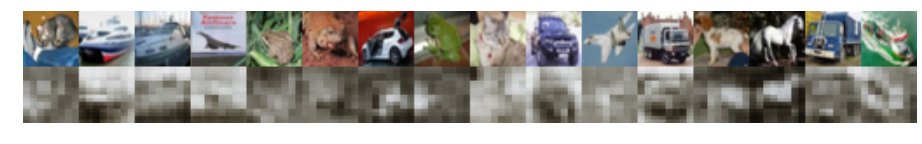


Starting Training Epoch 1
After 60000 training examples, training error = 0.12419
After 70000 training examples, training error = 0.12096
After 80000 training examples, training error = 0.12585
After 90000 training examples, training error = 0.12012
After 100000 training examples, training error = 0.11374

After 100000 training examples, test error = 0.11808


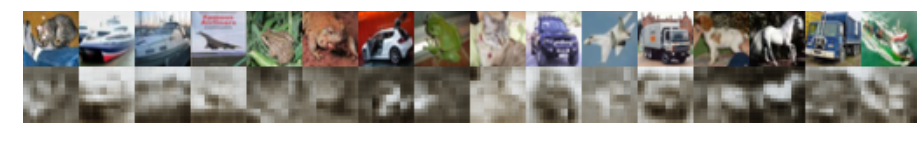


Starting Training Epoch 2
After 110000 training examples, training error = 0.11751
After 120000 training examples, training error = 0.11410
After 130000 training examples, training error = 0.11455
After 140000 training examples, training error = 0.10923
After 150000 training examples, training error = 0.10209

After 150000 training examples, test error = 0.10585


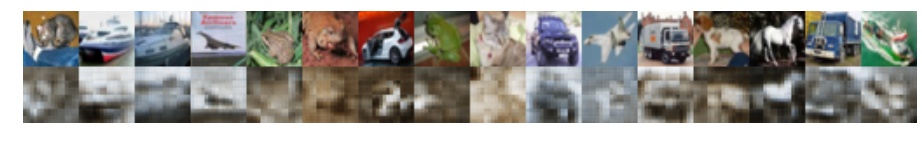


Starting Training Epoch 3
After 160000 training examples, training error = 0.10670
After 170000 training examples, training error = 0.10051
After 180000 training examples, training error = 0.09649
After 190000 training examples, training error = 0.09952
After 200000 training examples, training error = 0.10195

After 200000 training examples, test error = 0.09694


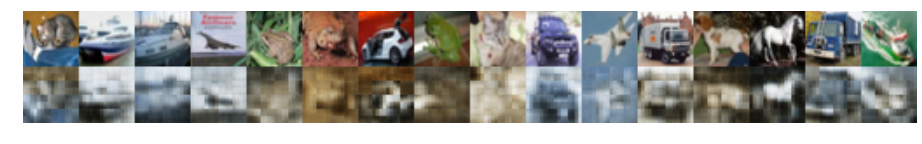


Starting Training Epoch 4
After 210000 training examples, training error = 0.09368
After 220000 training examples, training error = 0.09211
After 230000 training examples, training error = 0.08854
After 240000 training examples, training error = 0.09307
After 250000 training examples, training error = 0.08948

After 250000 training examples, test error = 0.09077


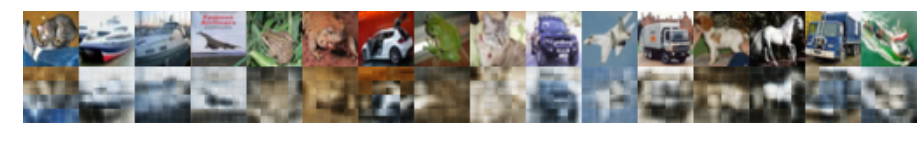


Starting Training Epoch 5
After 260000 training examples, training error = 0.09041
After 270000 training examples, training error = 0.08528
After 280000 training examples, training error = 0.08760
After 290000 training examples, training error = 0.08764
After 300000 training examples, training error = 0.08931

After 300000 training examples, test error = 0.08832


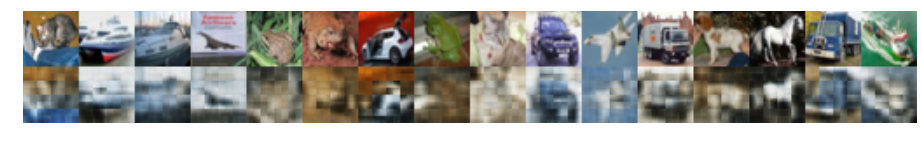


Starting Training Epoch 6
After 310000 training examples, training error = 0.08533
After 320000 training examples, training error = 0.08650
After 330000 training examples, training error = 0.08685
After 340000 training examples, training error = 0.08603
After 350000 training examples, training error = 0.08358

After 350000 training examples, test error = 0.08627


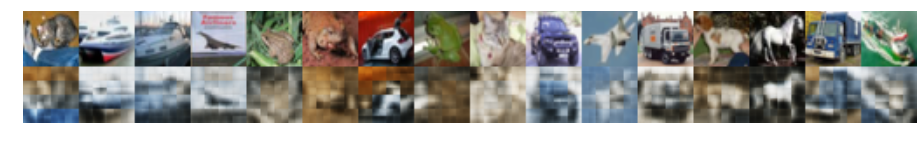


Starting Training Epoch 7
After 360000 training examples, training error = 0.08171
After 370000 training examples, training error = 0.08291
After 380000 training examples, training error = 0.08455
After 390000 training examples, training error = 0.08374
After 400000 training examples, training error = 0.08129

After 400000 training examples, test error = 0.08452


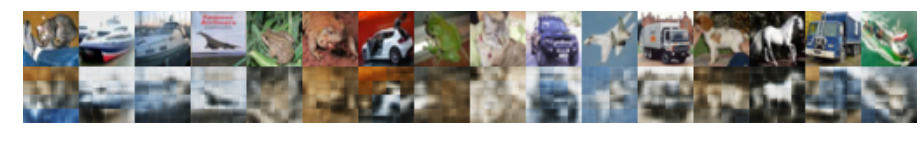


Starting Training Epoch 8
After 410000 training examples, training error = 0.08497
After 420000 training examples, training error = 0.08240
After 430000 training examples, training error = 0.08460
After 440000 training examples, training error = 0.07811
After 450000 training examples, training error = 0.08267

After 450000 training examples, test error = 0.08305


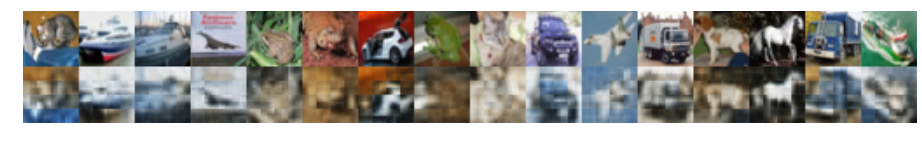


Starting Training Epoch 9
After 460000 training examples, training error = 0.08256
After 470000 training examples, training error = 0.07846
After 480000 training examples, training error = 0.08130
After 490000 training examples, training error = 0.08035
After 500000 training examples, training error = 0.07731

After 500000 training examples, test error = 0.08181


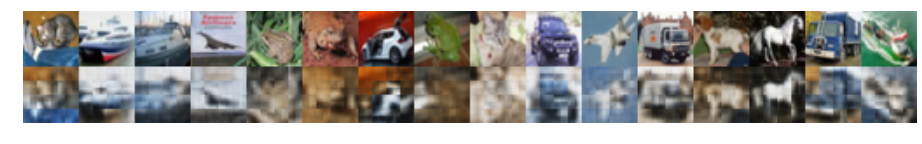

In [123]:
secd.Train(
    train_images=train_images,
    test_images=test_batch[:100],
    batch_size=100,
    learn_rate=0.001,
    epochs=10,
    report_every_n_batches=100,
    show_examples=True)

You can see that whilethe convolutional and simple decoders achieve similar rates of error reduction over the course of the first epoch, they learn very different things. The simple decoder learns blobs of color at the center and periphery of the image, while the convolutional decoder learns rough shapes in greyscale. Let's let it go for another ten epochs!


After 500000 training examples, test error = 0.08181

Starting Training Epoch 0
After 510000 training examples, training error = 0.08184
After 520000 training examples, training error = 0.08129
After 530000 training examples, training error = 0.07949
After 540000 training examples, training error = 0.07957
After 550000 training examples, training error = 0.08143

After 550000 training examples, test error = 0.08033


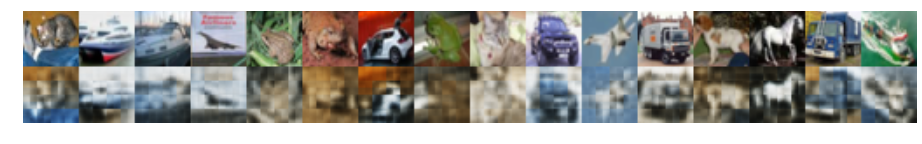


Starting Training Epoch 1
After 560000 training examples, training error = 0.07797
After 570000 training examples, training error = 0.07703
After 580000 training examples, training error = 0.07897
After 590000 training examples, training error = 0.08034
After 600000 training examples, training error = 0.07953

After 600000 training examples, test error = 0.07961


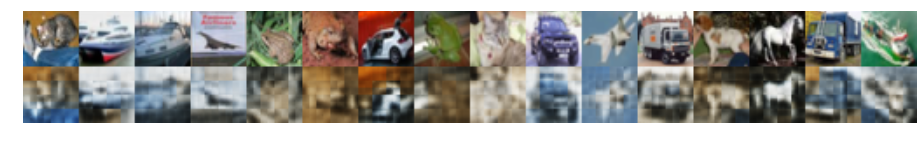


Starting Training Epoch 2
After 610000 training examples, training error = 0.07604
After 620000 training examples, training error = 0.07693
After 630000 training examples, training error = 0.07429
After 640000 training examples, training error = 0.07478
After 650000 training examples, training error = 0.07429

After 650000 training examples, test error = 0.07885


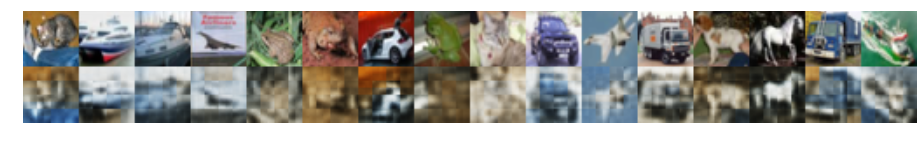


Starting Training Epoch 3
After 660000 training examples, training error = 0.07808
After 670000 training examples, training error = 0.07950
After 680000 training examples, training error = 0.07903
After 690000 training examples, training error = 0.07625
After 700000 training examples, training error = 0.07657

After 700000 training examples, test error = 0.07900


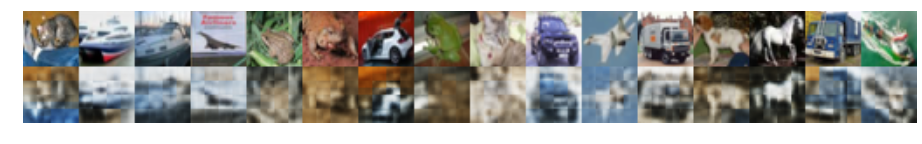


Starting Training Epoch 4
After 710000 training examples, training error = 0.07798
After 720000 training examples, training error = 0.07886
After 730000 training examples, training error = 0.07998
After 740000 training examples, training error = 0.07683
After 750000 training examples, training error = 0.07998

After 750000 training examples, test error = 0.07798


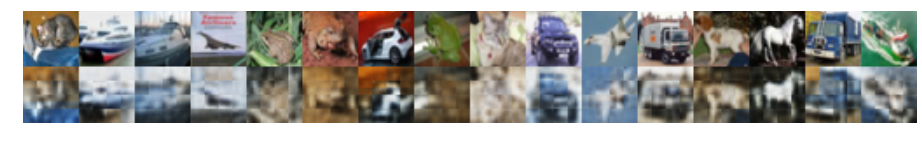


Starting Training Epoch 5
After 760000 training examples, training error = 0.07496
After 770000 training examples, training error = 0.08347
After 780000 training examples, training error = 0.07544
After 790000 training examples, training error = 0.07671
After 800000 training examples, training error = 0.08048

After 800000 training examples, test error = 0.07749


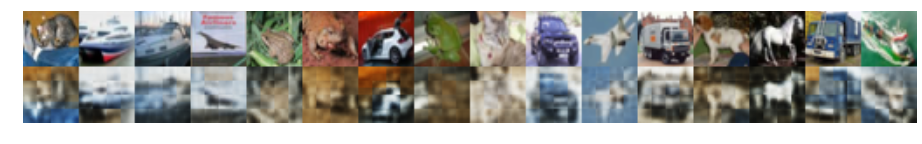


Starting Training Epoch 6
After 810000 training examples, training error = 0.07380
After 820000 training examples, training error = 0.07692
After 830000 training examples, training error = 0.07723
After 840000 training examples, training error = 0.07230
After 850000 training examples, training error = 0.07787

After 850000 training examples, test error = 0.07713


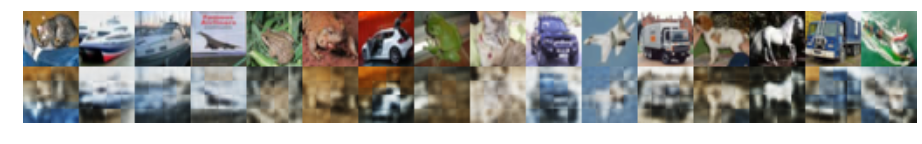


Starting Training Epoch 7
After 860000 training examples, training error = 0.07754
After 870000 training examples, training error = 0.07697
After 880000 training examples, training error = 0.07833
After 890000 training examples, training error = 0.07843
After 900000 training examples, training error = 0.07758

After 900000 training examples, test error = 0.07752


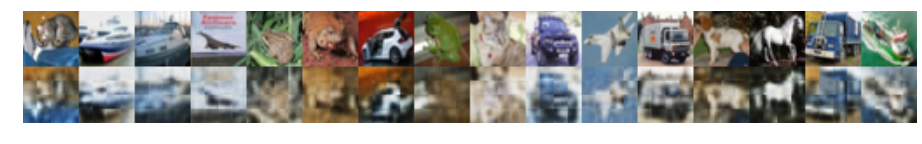


Starting Training Epoch 8
After 910000 training examples, training error = 0.07685
After 920000 training examples, training error = 0.07515
After 930000 training examples, training error = 0.07400
After 940000 training examples, training error = 0.07949
After 950000 training examples, training error = 0.07278

After 950000 training examples, test error = 0.07697


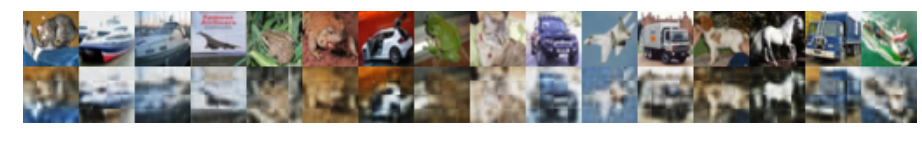


Starting Training Epoch 9
After 960000 training examples, training error = 0.07377
After 970000 training examples, training error = 0.07902
After 980000 training examples, training error = 0.07567
After 990000 training examples, training error = 0.07968
After 1000000 training examples, training error = 0.07434

After 1000000 training examples, test error = 0.07703


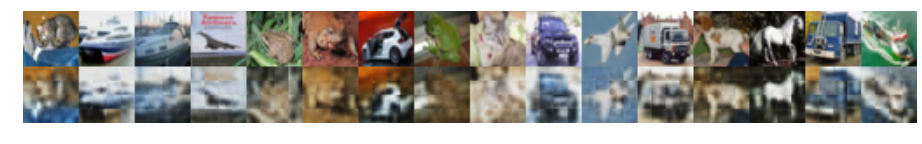

In [124]:
secd.Train(
    train_images=train_images,
    test_images=test_batch[:100],
    batch_size=100,
    learn_rate=0.001,
    epochs=10,
    report_every_n_batches=100,
    show_examples=True)